In [92]:
import sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random
import copy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

import os, sys

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

import tensorflow as tf

from collections import deque

import keras

from keras.layers import Dense, Flatten, Input,Dropout,Concatenate,Reshape,Multiply
from keras.layers.embeddings import Embedding
from keras.layers.core import Lambda
from keras.models import Sequential,Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
import keras.backend as K
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.models import load_model


In [93]:
Zoom=13
CALCULATOR = dgckernel.Calculator()
CALCULATOR.SetLayer(Zoom)

'''GRID ID'''

def get_grid(lng,lat):

    return CALCULATOR.HexCellKey(dgckernel.GeoCoord(lat, lng))

'''GRID SHAPE'''

def get_grid_shape(grid):

    return CALCULATOR.HexCellVertexesAndCenter(grid)

'''Neighbor Grid'''

def grid_neighbor(grid, low_layer, up_layer):

    neighbors = CALCULATOR.HexCellNeighbor(grid, up_layer)
    _neighbors = CALCULATOR.HexCellNeighbor(grid, low_layer)
    neighbors = [e for e in neighbors if e not in _neighbors]
    return neighbors

'''获取一定范围内的格子'''

def grid_eliminate(grid_list,sw,ne):
    grid_result=list()
    for grid in grid_list:
        v_f,c_f=get_grid_shape(grid)
        c_lng,c_lat=c_f.lng,c_f.lat;
        if c_lng>=sw[1] and c_lng<=ne[1] and c_lat>=sw[0] and c_lat<=ne[0]:
            grid_result.append(grid)
    return grid_result

'''经纬度距离转直线距离'''

def Geo_distance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) 
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    distance=2*asin(sqrt(a))*6371 
    distance=round(distance,2)
    return distance


'''获取格子之间的路面距离'''

def get_grid_dis(f_grid,t_grid):
    
    f_shape,f_center=get_grid_shape(f_grid);
    t_shape,t_center=get_grid_shape(t_grid);
    
    Topology_dis=1.3*Geo_distance(f_center.lng,f_center.lat,t_center.lng,t_center.lat)
    
    return Topology_dis



'''Time stamp'''
def stamp_transit(time_str):
    timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    timeStamp = int(time.mktime(timeArray))
    return timeStamp
    
'''Time step'''

def stamp_to_step(timestamp,date_str,step):
    baseline = date_str+" 00:00:00";
    baseline = int(stamp_transit(baseline))
    current_step=int((timestamp-baseline)/step)
    return current_step

'''Drawing'''

def draw_bkg(sw,ne):
    
    '''Initial parameter'''
    bg_path='Chengdu_sample.png'
    
    '''Figure out'''
    img = plt.imread(bg_path)
    height, width = img.shape[:2]
    h1 = math.ceil(15./width*height)
    fig = plt.figure(figsize=(15,h1))
    ax = fig.add_subplot(111)
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    plt.xlim(xgrange)
    plt.ylim(ygrange)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.xticks(np.arange(xgrange[0], xgrange[1], 0.352/15))
    plt.yticks(np.arange(ygrange[0], ygrange[1], 0.2415/13))
    try:
        ax.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
    except:
        pass
    return fig, ax, xgrange, ygrange

# 0 Data initializing

In [94]:
'''Real Data Extracting'''

'''Request data'''

date_str='2016-11-01'

Request_data=pd.read_csv('Dataset/order_20161101.csv',header=None,\
                            names = ['Order_ID','Start_time','Stop_time','Pickup_Longitude','Pickup_Latitude',\
                                    'Dropoff_Longitude','Dropoff_Latitude','Reward_unit'])

Request_data['Pickup_Gird']=Request_data.apply(lambda x:get_grid(x['Pickup_Longitude'],x['Pickup_Latitude']),axis=1)

Request_data['Dropoff_Gird']=Request_data.apply(lambda x:get_grid(x['Dropoff_Longitude'],x['Dropoff_Latitude']),axis=1)

Request_data['Pickup_step']=Request_data.apply(lambda x:stamp_to_step(x['Start_time'],date_str,300), axis=1)

Request_data['Dropoff_step']=Request_data.apply(lambda x:stamp_to_step(x['Stop_time'],date_str,300), axis=1)

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

'''Trajectory data'''


Tracectory_data=pd.read_csv('./Experiments/Demo/gps20161101.csv')

Tracectory_data=Tracectory_data.drop(columns=['Unnamed: 0'])

Tracectory_data.columns = ['Driver_ID','Order_ID','Dispatch_step','lng','lng','Dispatch_Grid']

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step']].merge(Request_data[['Order_ID','Pickup_Gird']],on='Order_ID')


'''Idle_Transition data'''


Idle_Transition=pd.read_csv('Dataset/idle_transition_probability.csv',header=None,\
                            names = ['Hour','Origin_grid','Dest_grid','Prob'])

'''Grid noting'''

Grid_notes=pd.read_csv('./Experiments/Demo/hexagon_grid_table.csv',header=None,
                            names = ['Grid_id','v1_lng','v1_lat',\
                                    'v2_lng','v2_lat',\
                                    'v3_lng','v3_lat',\
                                    'v4_lng','v4_lat',\
                                    'v5_lng','v5_lat',\
                                    'v6_lng','v6_lat'])

Grid_notes=Grid_notes.dropna(subset=['v1_lng','v1_lat',\
                                    'v2_lng','v2_lat',\
                                    'v3_lng','v3_lat',\
                                    'v4_lng','v4_lat',\
                                    'v5_lng','v5_lat',\
                                    'v6_lng','v6_lat'])

Grid_notes['c_lng']=Grid_notes.apply(lambda x:(x['v1_lng']+x['v2_lng']+x['v3_lng']\
                                                               +x['v4_lng']+x['v5_lng']+x['v6_lng'])/6,axis=1)

Grid_notes['c_lat']=Grid_notes.apply(lambda x:(x['v1_lat']+x['v2_lat']+x['v3_lat']\
                                                               +x['v4_lat']+x['v5_lat']+x['v6_lat'])/6,axis=1)

Grid_notes=Grid_notes[['Grid_id','c_lng','c_lat']]

Grid_notes['grid']=Grid_notes.apply(lambda x:get_grid(x['c_lng'],x['c_lat']), axis=1)

Idle_Transition=Idle_Transition.merge(Grid_notes[['Grid_id','grid']],left_on='Origin_grid', right_on='Grid_id')

Idle_Transition=Idle_Transition[['Hour','grid','Dest_grid','Prob']]

Idle_Transition=Idle_Transition.rename(index=str, columns={"grid": "Origin_grid"})

Idle_Transition=Idle_Transition.merge(Grid_notes[['Grid_id','grid']],left_on='Dest_grid', right_on='Grid_id')

Idle_Transition=Idle_Transition[['Hour','Origin_grid','grid','Prob']]

Idle_Transition=Idle_Transition.rename(index=str, columns={"grid": "Dest_grid"})


# 01 Modeling

In [95]:
'''Overall range'''
# southwest=[30.331759, 103.512892]
# northeast=[30.944065, 104.640393]

'''Sample range'''

southwest=[30.617149, 104.014056]
northeast=[30.698437, 104.128742]

'''Time range'''

end_step=288


lng,lat=104.066218,30.656725
sample_grid=get_grid(lng,lat)
All_grid = grid_neighbor(sample_grid, 0, 70)
All_grid.append(sample_grid)
All_grid=grid_eliminate(All_grid,southwest,northeast)
Grid_range=pd.DataFrame(All_grid,columns=['grid'])


'''Data filtering'''

'''Request_data'''

Request_data=Request_data.merge(Grid_range,left_on='Pickup_Gird',right_on='grid')

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

Request_data=Request_data.merge(Grid_range,left_on='Dropoff_Gird',right_on='grid')

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

'''Tracectory_data'''

Tracectory_data=Tracectory_data.drop_duplicates(subset=['Driver_ID','Order_ID'], keep='first')

Tracectory_data=Tracectory_data.merge(Grid_range,left_on='Dispatch_Grid',right_on='grid')

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step','Pickup_Gird']]

Tracectory_data=Tracectory_data.merge(Grid_range,left_on='Pickup_Gird',right_on='grid')

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step','Pickup_Gird']]

'''Grid Screening'''

Idle_Transition=Idle_Transition.merge(Grid_range,left_on='Origin_grid',right_on='grid')

Idle_Transition=Idle_Transition[['Hour','Origin_grid','Dest_grid','Prob']]

Idle_Transition=Idle_Transition.merge(Grid_range,left_on='Dest_grid',right_on='grid')

Idle_Transition=Idle_Transition[['Hour','Origin_grid','Dest_grid','Prob']]

In [96]:
'''State'''

State=list()
for grid in All_grid:
    for t_step in range(end_step):
        State.append(str(grid)+'-'+str(t_step))
        
State_range=pd.DataFrame(State,columns=['State'])

'''Action'''

Action_space={}

for idx,row in Grid_range.iterrows():
    
    grid=row['grid']
    
    for t_step in range(end_step):
        
        state=grid+'-'+str(t_step)
        
        Action_candidate=grid_neighbor(grid, 0, 1)+[grid]
        
        Action_list=grid_eliminate(Action_candidate,southwest,northeast)
        
        Action_space[state]=Action_list
        
'''State Action'''

State_list=list()
Action_list=list()

for state in State:
    for action in Action_space[state]:
        State_list.append(state)
        Action_list.append(action)

State_Action=pd.DataFrame(State_list,columns=['State'])
State_Action['Action']=Action_list
        

In [97]:
'''State Action reward'''

State_Action_reward=Tracectory_data.merge(Request_data[['Order_ID','Reward_unit']],on='Order_ID')

State_Action_reward=State_Action_reward[['Dispatch_Grid','Dispatch_step','Reward_unit']]

State_Action_reward['Next_state']=State_Action_reward.apply(lambda x:x['Dispatch_Grid']+'-'+str(x['Dispatch_step']),axis=1)

State_Action_reward['step']=State_Action_reward.apply(lambda x:x['Dispatch_step']-1,axis=1)

State_Action_reward['grid']=State_Action_reward.apply(lambda x:random.choice(Action_space[x['Next_state']]),axis=1)

State_Action_reward['State']=State_Action_reward.apply(lambda x:x['grid']+'-'+str(x['step']),axis=1)

State_Action_reward['Action']=State_Action_reward['Dispatch_Grid']

State_Action_reward=State_Action_reward[['State','Action','Reward_unit']]

State_Action_reward=State_Action_reward.groupby(['State','Action']).mean()[['Reward_unit']]

State_Action_reward['Transition']=State_Action_reward.index

State_Action_reward['State']=State_Action_reward.apply(lambda x:x['Transition'][0],axis=1)

State_Action_reward['Action']=State_Action_reward.apply(lambda x:x['Transition'][1],axis=1)

State_Action_reward=State_Action_reward.reset_index(drop=True)

State_Action_reward=State_Action_reward[['State','Action','Reward_unit']]

State_Action_reward=State_Action.merge(State_Action_reward,on=['State','Action'],how='left')

State_Action_reward=State_Action_reward.fillna(0.0)

Reward={}

for idx,row in State_Action_reward.iterrows():
    
    Reward[row['State']+'+'+row['Action']]=row['Reward_unit']



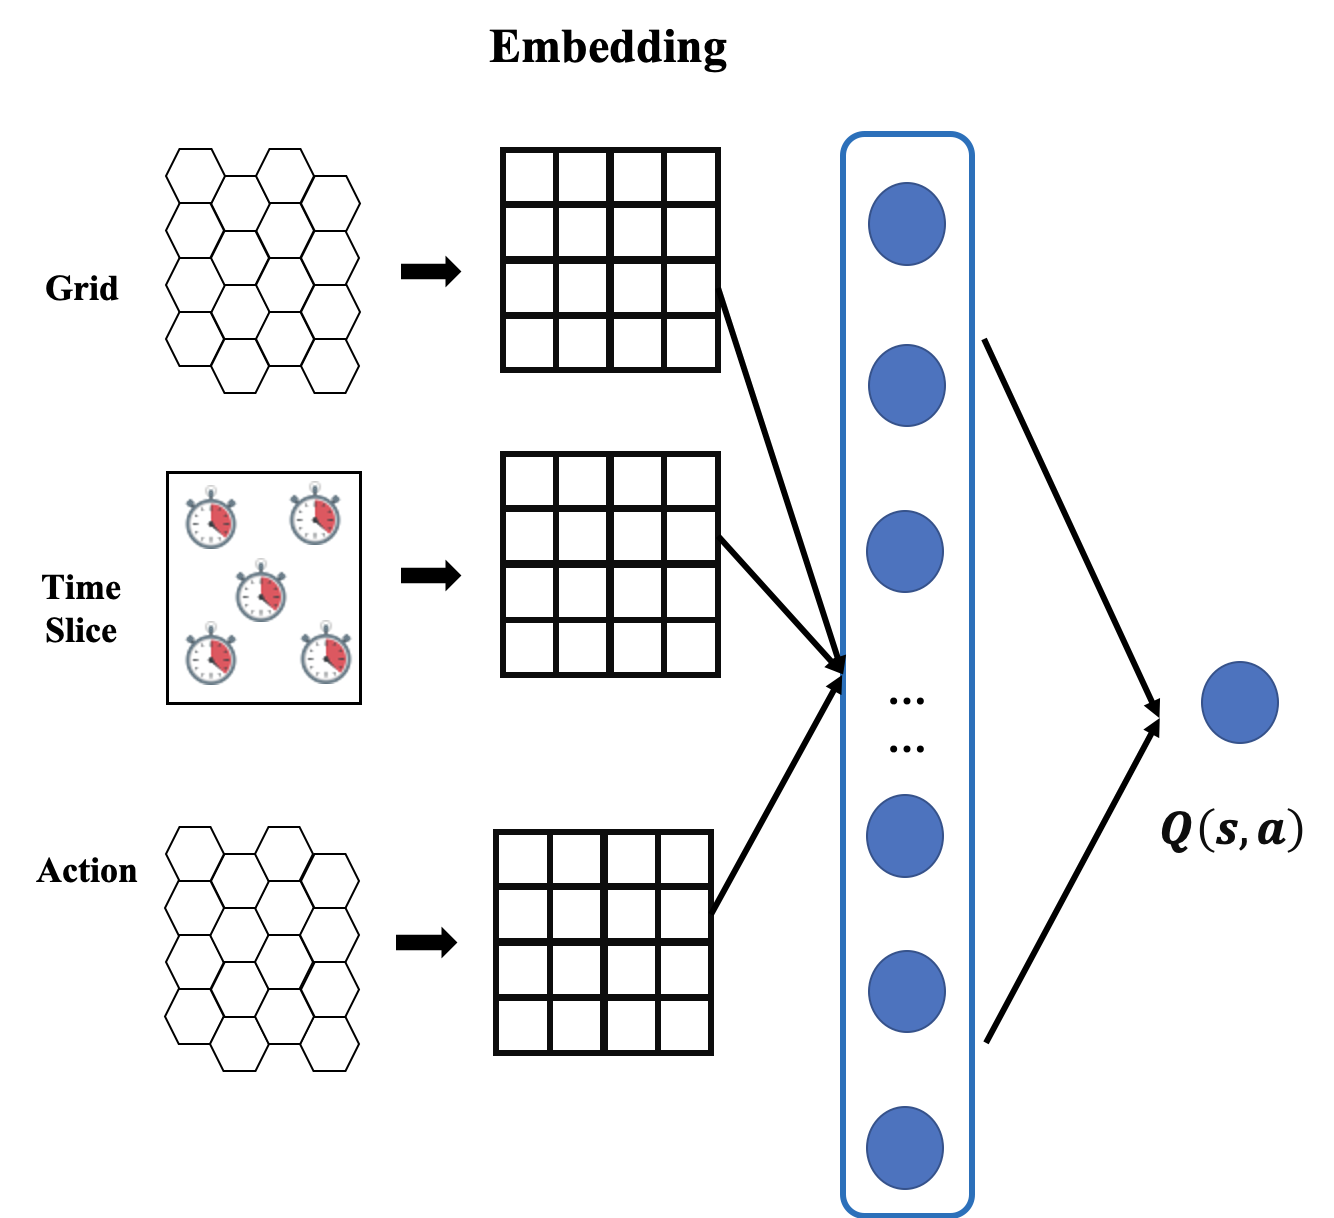

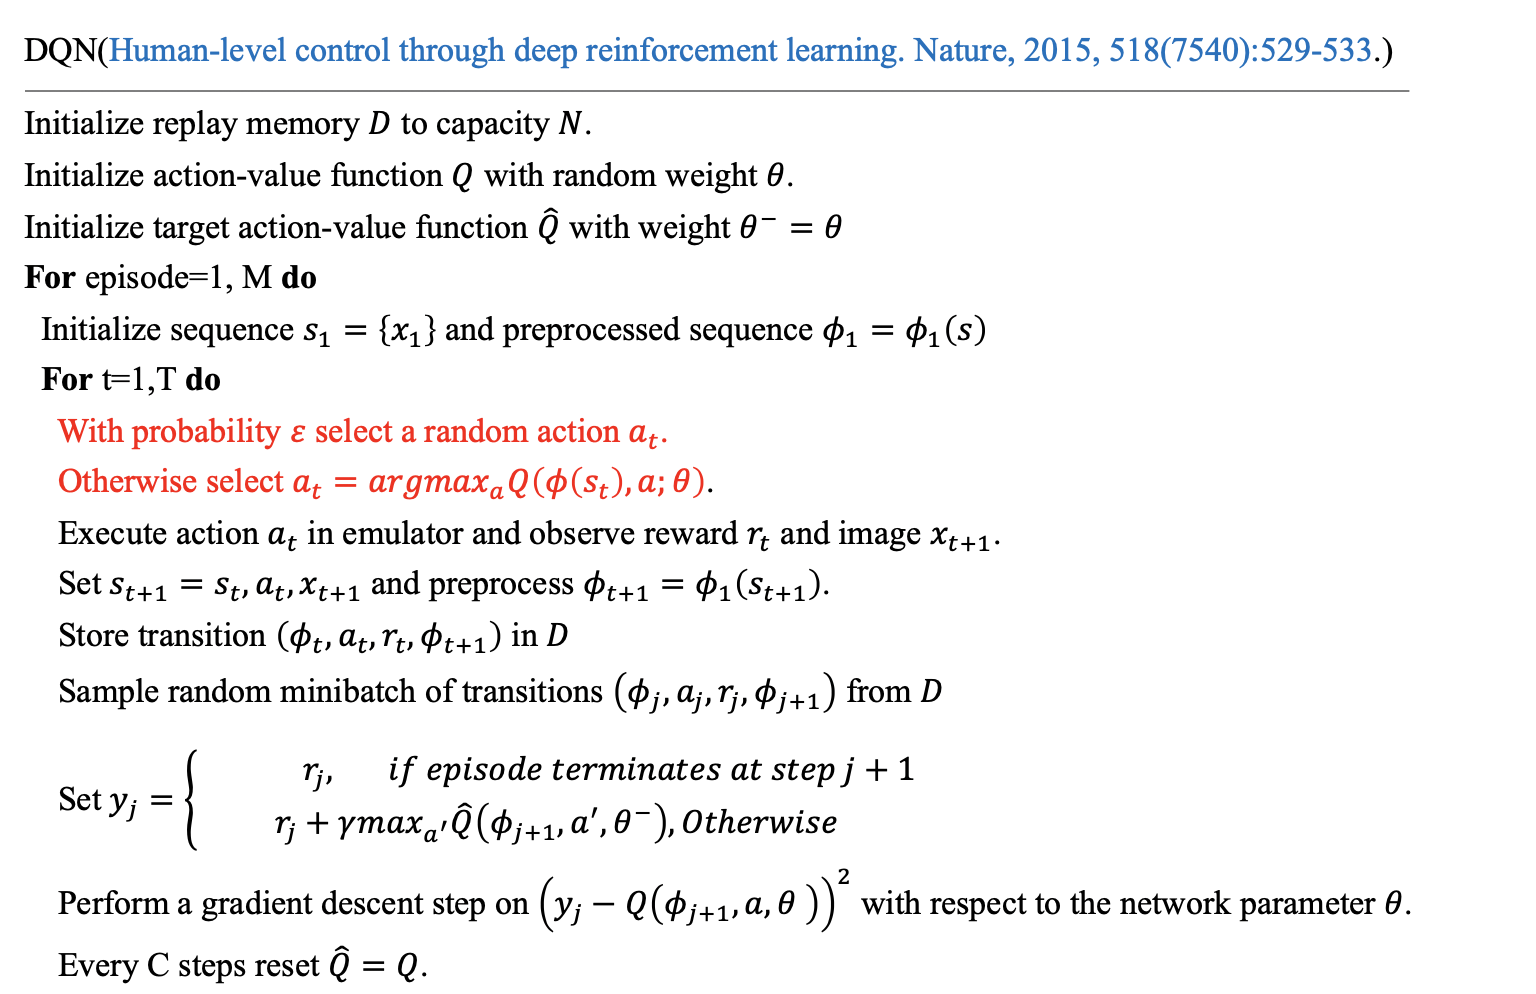

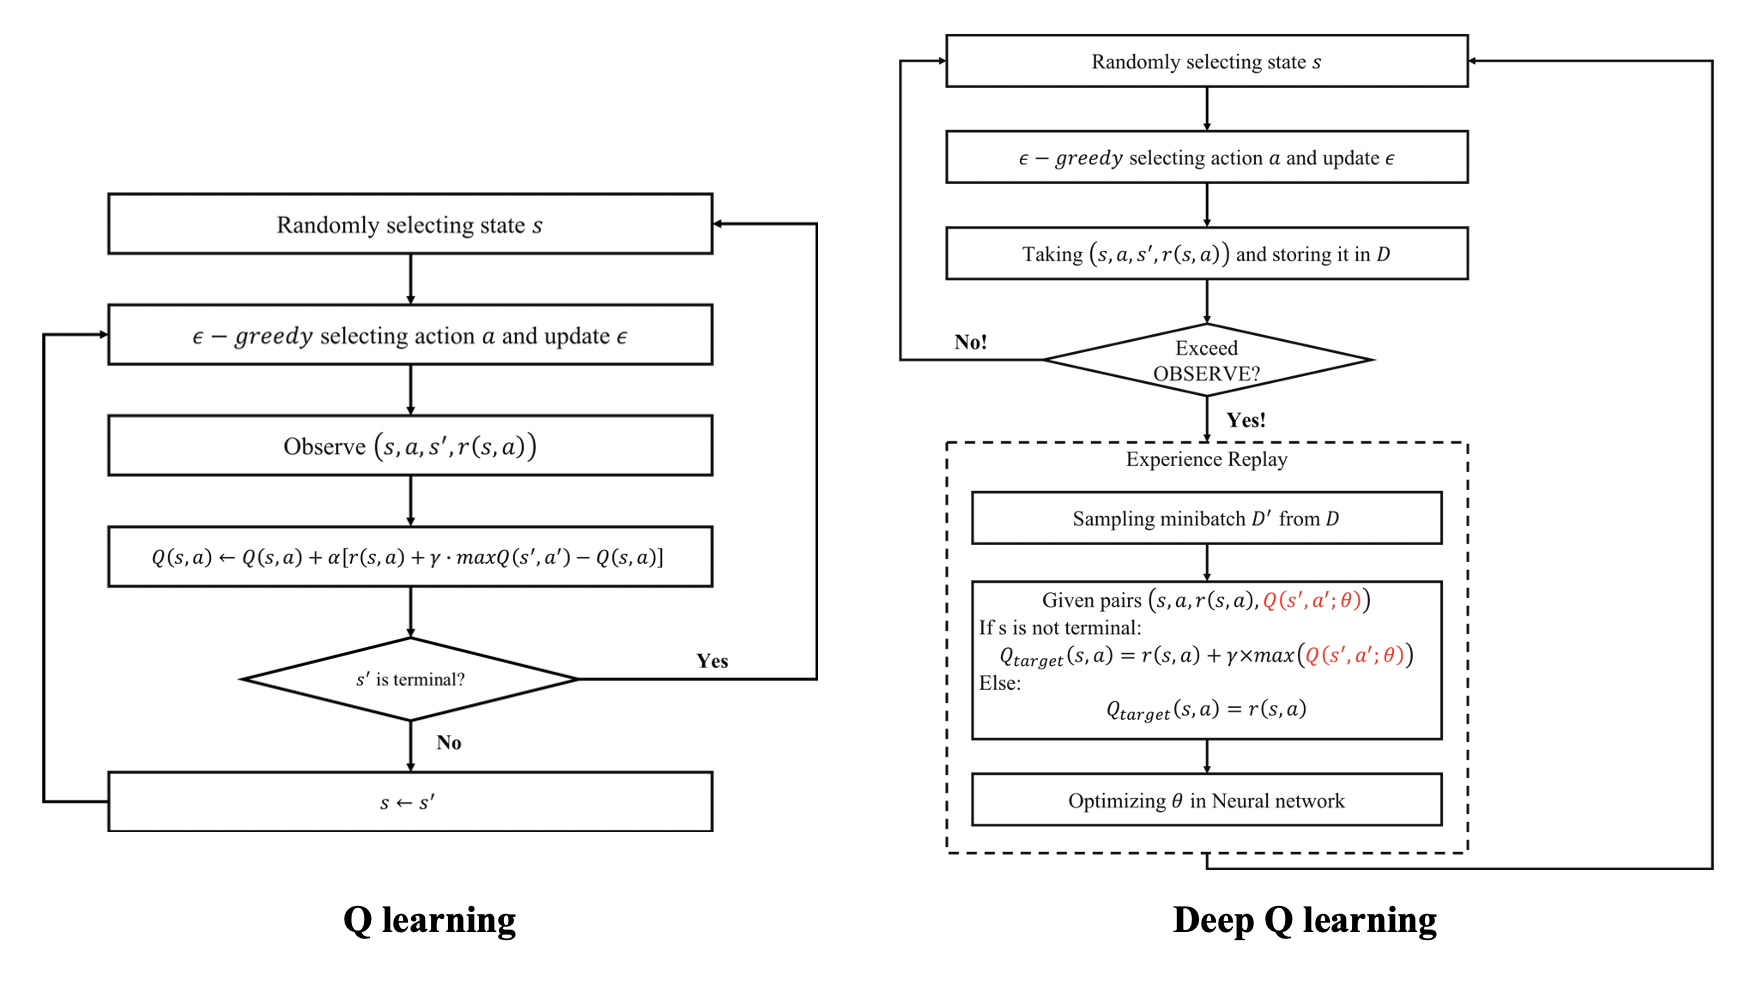

In [98]:
class DeepQNetwork():
    
    def __init__(self,Grid,State,Action,Reward):
        
        '''Basic parameter'''
        
        self.learning_rate = 0.001
        
        self.gamma = 0.9
        
        '''Experience memory'''
        
        self.memory_size = 500000
        
        self.memory_bound = 1000
        
        self.memory_counter = 0
        
        self.replay_memory_store = list()
        
        '''Epsilon'''
        
        self.epsilon = 1
        
        self.epsilon_decay = 0.995
        
        self.epsilon_min = 0.01
     
        '''Batch'''

        self.BATCH = 50
        
        '''Iteration'''
        
        self.Episode=40

        
        '''Network parameter'''
        
        self.Grid=Grid
        
        self.grid_scale = len(Grid)
        
        self.stamp_scale = 288
        
        self.action_scale = len(Grid)
        
        '''Feeding data'''
        
        self.State = State
        
        self.Action = Action
        
        self.Reward = Reward
        
        self.State_num=len(self.State)
        
        '''Network'''
    
        self.QNetwork=self.Build_network()
        
        self.losses=list()
        
    def decipher(self, X,vocab_size):
        
        '''
        Input: text list
        Output: decode list
        '''

        encoded_x = [one_hot(x, vocab_size) for x in X]

        padded_x = pad_sequences(encoded_x,padding='post')

        padded_x= np.array([item[0] for item in padded_x])

        return padded_x

    def Build_network(self):
        
        '''
        Initialize the Network
        
        '''

        inputs = []

        embeddings = []

        '''Grid processing layer'''

        grid_feature=Input(shape=(1,))

        embedding = Embedding(self.grid_scale, 16, input_length=1)(grid_feature)

        embedding = Reshape(target_shape=(16,))(embedding)

        inputs.append(grid_feature)

        embeddings.append(embedding)

        '''Stamp processing layer'''

        stamp_feature=Input(shape=(1,))

        embedding = Embedding(self.stamp_scale, 8, input_length=1)(stamp_feature)

        embedding = Reshape(target_shape=(8,))(embedding)

        inputs.append(stamp_feature)

        embeddings.append(embedding)

        '''Action processing layer'''

        action_feature=Input(shape=(1,))

        embedding = Embedding(self.action_scale, 16, input_length=1)(action_feature)

        embedding = Reshape(target_shape=(16,))(embedding)

        inputs.append(action_feature)

        embeddings.append(embedding)
        

        '''Concatenate layer'''

        x = Concatenate()(embeddings)

        '''Dense layer'''

        x = Dense(16, activation='relu')(x)

        x = Dense(32, activation='relu')(x)

        x = Dropout(0.2)(x)

        '''Out put'''

        outputs = Dense(1)(x)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer=Adam(1e-3), loss='mse')

        return model
    
    def Pred_Qvalue(self, Network, State_array,Action_array):
        
        '''
        Input: State_array,Action_array
        Output: Q_value array
        '''
            
        Grid_array=np.array([state.split('-')[0] for state in State_array])

        Stamp_array=np.array([state.split('-')[1] for state in State_array])
            
        Pred_X=[]

        Pred_Encode_Grid=self.decipher(Grid_array,self.grid_scale);
        Pred_Encode_Action=self.decipher(Action_array,self.action_scale)

        Pred_X.append(Pred_Encode_Grid);
        Pred_X.append(Stamp_array);
        Pred_X.append(Pred_Encode_Action);

        Pred_Q=Network.predict(Pred_X)[:,0]
        
        return Pred_Q
    
    def Update_QNetwork(self, State_array,Action_array,Q_target):
        
        '''
        Input: State_array,Action_array,Q_target
        Output: Updated QNetwork
        '''
            
        Grid_array=np.array([state.split('-')[0] for state in State_array])

        Stamp_array=np.array([state.split('-')[1] for state in State_array])
            
        Pred_X=[]

        Pred_Encode_Grid=self.decipher(Grid_array,self.grid_scale);
        Pred_Encode_Action=self.decipher(Action_array,self.action_scale)

        Pred_X.append(Pred_Encode_Grid);
        Pred_X.append(Stamp_array);
        Pred_X.append(Pred_Encode_Action);


        loss = self.QNetwork.train_on_batch(Pred_X, Q_target)
        
        self.losses.append(loss)

    
    def Select_action(self, current_state):
        
        """
        Input: current state
        Output: selected action
        """
        
        Action_array=np.array(self.Action[current_state])
        
        action_num=len(Action_array)
        
        State_array=np.array([current_state for i in range(action_num)])
        
        if np.random.rand() < self.epsilon:
            
            current_action= Action_array[np.random.randint(0, action_num)]
            
        else:
            
            Pred_Q_array=self.Pred_Qvalue(self.QNetwork,State_array,Action_array)
            
            action_index = np.argmax(Pred_Q_array)
            
            current_action = Action_array[action_index]

        return current_action
    
    def update_epsilon(self):
        
        """
        Update epsilon
        
        """
        if self.epsilon >= self.epsilon_min:
            
            self.epsilon *= self.epsilon_decay
    
    def Query(self, state, action):
        
        """
        Input: state, action
        Output: next_state, reward, done
        
        """
        
        reward = self.Reward[state+'+'+action]
        
        current_grid=state.split('-')[0];
        
        current_stamp=int(state.split('-')[1])
        
        next_grid=action;
        
        next_stamp=current_stamp+1

        next_state = next_grid+'-'+str(next_stamp)

        done = True

        if current_stamp >= self.stamp_scale or next_stamp>= self.stamp_scale:
            
            done = False

        return next_state, reward, done
    
    def Save_store(self, current_state, current_action, current_reward, next_state, done):
        
        '''Store the trace'''
        
        item=(current_state,current_action,current_reward,next_state,done)
        
        self.replay_memory_store.append(item)
        
        if self.memory_counter>=self.memory_size:
            
            self.replay_memory_store.pop(0)

        self.memory_counter += 1
        
    def experience_replay(self):
        
        """
        Core procedure
        
        """
        
        minibatch = random.sample(self.replay_memory_store, self.BATCH)

        batch_state = None
        batch_action = None
        batch_reward = None
        batch_next_state = None
        batch_done = None
        
        '''
        
        replay_memory_store:
        0:current_state,
        1:current_action,
        2:current_reward,
        3:next_state,
        4:done
        
        '''
        
        for index in range(len(minibatch)):
            
            if batch_state is None:
                batch_state = minibatch[index][0]
            elif batch_state is not None:
                batch_state = np.vstack((batch_state, minibatch[index][0]))

            if batch_action is None:
                batch_action = minibatch[index][1]
            elif batch_action is not None:
                batch_action = np.vstack((batch_action, minibatch[index][1]))

            if batch_reward is None:
                batch_reward = minibatch[index][2]
            elif batch_reward is not None:
                batch_reward = np.vstack((batch_reward, minibatch[index][2]))

            if batch_next_state is None:
                batch_next_state = minibatch[index][3]
            elif batch_next_state is not None:
                batch_next_state = np.vstack((batch_next_state, minibatch[index][3]))

            if batch_done is None:
                batch_done = minibatch[index][4]
            elif batch_done is not None:
                batch_done = np.vstack((batch_done, minibatch[index][4]))
                
        batch_state=np.array([item[0] for item in batch_state])
        batch_action=np.array([item[0] for item in batch_action])
        batch_reward=np.array([item[0] for item in batch_reward])
        batch_next_state=np.array([item[0] for item in batch_next_state])
        batch_done=np.array([item[0] for item in batch_done])
        
        '''Predict the Q value of the next state'''
        
        Q_next=[]
        
        for next_state in batch_next_state:
            
            Action_array=np.array(self.Action[next_state])
            
            action_num=len(Action_array)
        
            State_array=np.array([next_state for i in range(action_num)])
            
            Pred_Q_array=self.Pred_Qvalue(self.QNetwork,State_array,Action_array)
            
            Q_next.append(Pred_Q_array)
            
        '''Update Q-target'''
            
        Q_target = []
        
        for i in range(len(minibatch)):
            
            current_reward = batch_reward[i]

            Q_value = current_reward + self.gamma * np.max(Q_next[i])
            
            Q_target.append(Q_value)
        
        Q_target=np.array(Q_target)
        
        '''Update QNetwork'''
        
        self.Update_QNetwork(batch_state,batch_action, Q_target)
    
        
    
    def Train(self):
        
        """
        Training QNetwork
        
        """
        for ep in range(self.Episode):
            
            episode_reward=0
        
            '''Random select current state'''
            
            current_state = self.State[np.random.randint(0, self.State_num - 1)]

            while True:

                
                action = self.Select_action(current_state)
                
                next_state, reward, done = self.Query(current_state, action)
                
                episode_reward+=reward
                
                if done:

                    self.Save_store(current_state, action, reward, next_state, done)

                    current_state = next_state
                    
                    if self.memory_counter >=self.memory_bound:

                        self.experience_replay()

                        self.update_epsilon()

                else:

                    break 
                    
                    
        self.QNetwork.save('DQN.h5')
        Losses=pd.DataFrame(self.losses,columns=['loss'])
        Losses.to_csv('DQN_losses.csv')
        
    def Pred_Qvalue(self, Network,State_array,Action_array):
        
        '''
        Input: State_array,Action_array
        Output: Q_value array
        '''
            
        Grid_array=np.array([state.split('-')[0] for state in State_array])
        Stamp_array=np.array([state.split('-')[1] for state in State_array])
            
        Pred_X=[]

        Pred_Encode_Grid=self.decipher(Grid_array,self.grid_scale);
        Pred_Encode_Action=self.decipher(Action_array,self.action_scale)

        Pred_X.append(Pred_Encode_Grid);
        Pred_X.append(Stamp_array);
        Pred_X.append(Pred_Encode_Action);


        Pred_Q=Network.predict(Pred_X)[:,0]
        
        return Pred_Q
            
        
    def Generate_policy(self,Network,sample_interval):
        
        '''
        Input: Grid,sample_interval
        Output: policy
        '''
        
        Policy=[]
        
        for grid in self.Grid:
            
            current_state=grid+'-'+str(sample_interval)
            
            Action_array=np.array(self.Action[current_state])
            
            action_num=len(Action_array)
        
            State_array=np.array([current_state for i in range(action_num)])
            
            Pred_Q_array=self.Pred_Qvalue(Network,State_array,Action_array)
                
            optimal_policy=Action_array[np.argmax(Pred_Q_array)]
            
            Policy.append(optimal_policy)
            
        return Policy
    

In [86]:
DQN=DeepQNetwork(All_grid,State,Action_space,Reward)
DQN.Train()


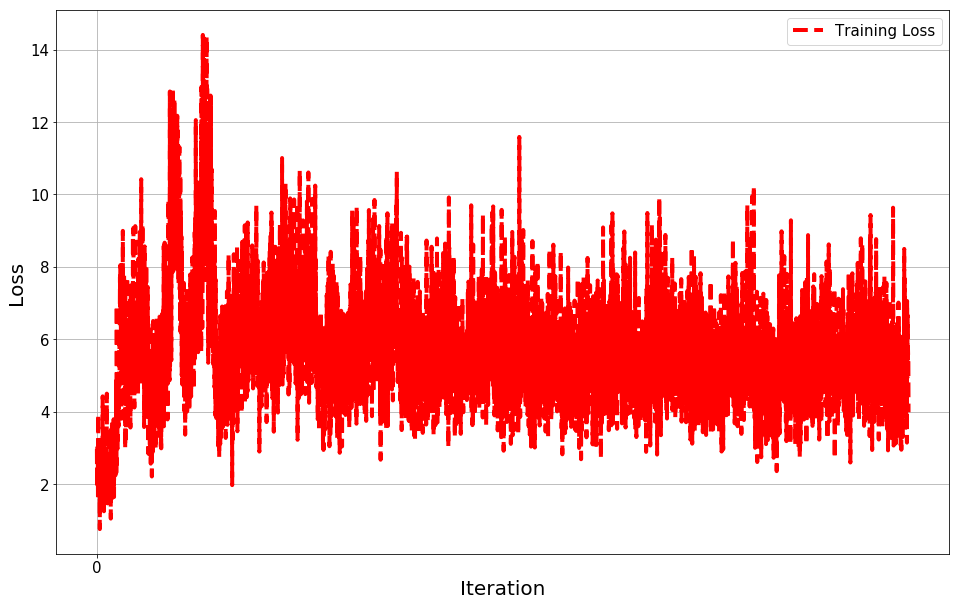

In [87]:
Losses=pd.read_csv('DQN_losses.csv')

'''Plot the losses'''

figsize = 16,10
figure,ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
font = {'weight' : 'normal','size': 20}

plt.plot(range(len(Losses['loss'])), Losses['loss'], 'r--', label='Training Loss',linewidth=4)

plt.grid()
plt.xlabel('Iteration',font)
plt.ylabel('Loss',font)
xmajorLocator   = MultipleLocator(20000)
ax.xaxis.set_major_locator(xmajorLocator) 
plt.legend(loc="upper right",fontsize=15)

plt.show()

In [88]:
QNetwork = load_model('DQN.h5')

'''Demo'''

grid='OL13F1i6602j1654'

stamp='120'


State_array=np.array([grid+'-'+stamp for a in Action_space[state]])
Action_array=np.array(Action_space[state])


Pred_Q_array=DQN.Pred_Qvalue(QNetwork,State_array,Action_array)

Pred_Q_array




array([20.950253, 23.215769, 22.115873, 21.453314, 23.559366, 22.266397,
       21.980677], dtype=float32)

In [89]:
'''Macth probability'''

Match_PROB=Request_data.groupby(['Pickup_Gird','Pickup_step']).count()[['Order_ID']]

Match_PROB['Transition']=Match_PROB.index

Match_PROB['Pickup_Gird']=Match_PROB.apply(lambda x:x['Transition'][0],axis=1)

Match_PROB['Pickup_step']=Match_PROB.apply(lambda x:x['Transition'][1],axis=1)

Match_PROB=Match_PROB.reset_index(drop=True)

Match_PROB=Match_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Match_PROB=Match_PROB[['Pickup_Gird','Pickup_step','Order_Cnt']]

Match_PROB['State']=Match_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Match_PROB['Prob']=Match_PROB.apply(lambda x:round(x['Order_Cnt']/4.0,2) if x['Order_Cnt']<=4 else 1.00,axis=1)

Match_PROB=Match_PROB[['State','Prob']]

Match_PROB=State_range.merge(Match_PROB,on='State',how='left')

Match_PROB=Match_PROB.fillna(0.0)

In [90]:
'''预测时间片为120的策略'''

sample_step=120
Policy=DQN.Generate_policy(QNetwork,sample_step)

Polciy_table=pd.DataFrame(All_grid,columns=['grid'])
Polciy_table['stamp']=sample_step
Polciy_table['Policy']=Policy

Polciy_table


Weight=Match_PROB

Weight['grid']=Weight.apply(lambda x:x['State'].split('-')[0],axis=1)

Weight['stamp']=Weight.apply(lambda x:int(x['State'].split('-')[1]),axis=1)

Weight=Weight[['grid','stamp','Prob']]

Weight=Weight.loc[Weight['stamp']==sample_step]

Polciy_table=Polciy_table.merge(Weight,on=['grid','stamp'])

Polciy_table['weight'] = 0.5*Polciy_table['Prob'] 

Polciy_table

,grid,stamp,Policy,Prob,weight
0,OL13F1i6602j1654,120,OL13F1i6602j1653,0.75,0.375
1,OL13F1i6602j1653,120,OL13F1i6602j1653,1.00,0.500
2,OL13F1i6601j1653,120,OL13F1i6602j1653,1.00,0.500
3,OL13F1i6600j1654,120,OL13F1i6600j1655,1.00,0.500
4,OL13F1i6600j1655,120,OL13F1i6600j1655,1.00,0.500
5,OL13F1i6601j1655,120,OL13F1i6600j1655,1.00,0.500
6,OL13F1i6603j1654,120,OL13F1i6603j1653,1.00,0.500
7,OL13F1i6603j1653,120,OL13F1i6602j1653,1.00,0.500
8,OL13F1i6603j1652,120,OL13F1i6602j1653,0.50,0.250
9,OL13F1i6602j1652,120,OL13F1i6602j1653,1.00,0.500


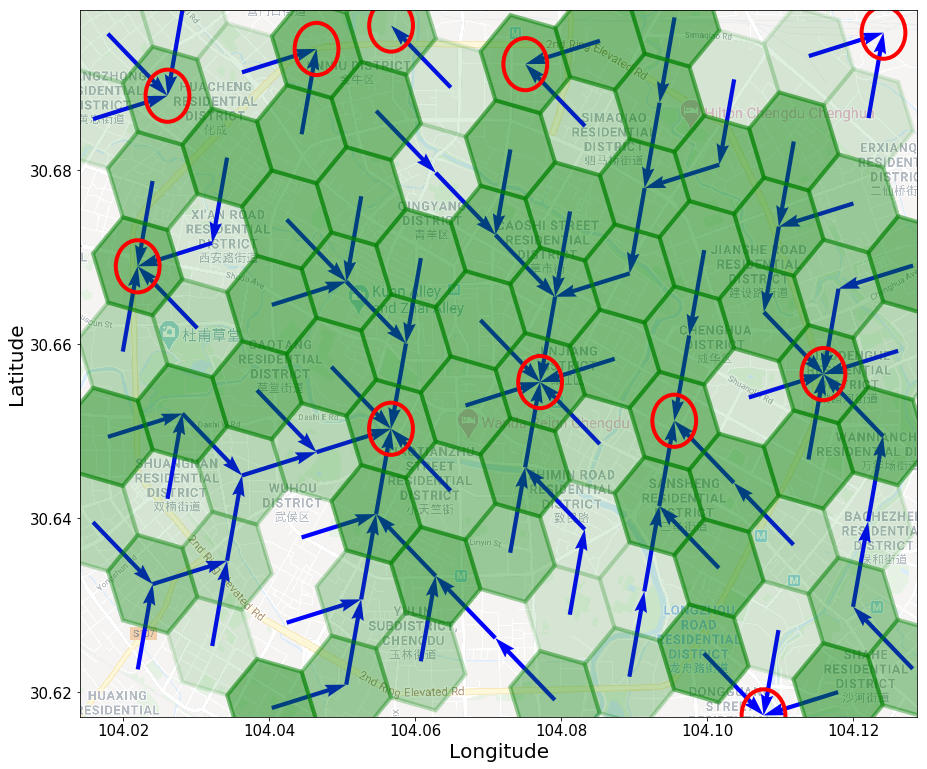

In [91]:
'''2 绘制网络连通性'''

fig, ax, xgrange, ygrange=draw_bkg(southwest,northeast)

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 15}
font_title = {'family' : 'Times New Roman','weight' : 'normal','size': 30}

    
for idx,row in Polciy_table.iterrows():
    
    pre_grid=row['grid']
    grid=row['Policy']
    
    vv_f,cc_f=get_grid_shape(pre_grid)
    v_f,c_f=get_grid_shape(grid)
    
    pgon = plt.Polygon(([vv_f[0].lng,vv_f[0].lat], [vv_f[1].lng,vv_f[1].lat], [vv_f[2].lng,vv_f[2].lat]\
                            ,[vv_f[3].lng,vv_f[3].lat],[vv_f[4].lng,vv_f[4].lat],[vv_f[5].lng,vv_f[5].lat]),color='g',linewidth=4,fill=True,alpha=row['weight'])

    plt.gca().add_patch(pgon)

    X_1 =round(cc_f.lng,5)
    Y_1 =round(cc_f.lat,5)
    X_2 =round(c_f.lng,5)
    Y_2=round(c_f.lat,5)
    
    U = round(X_2-X_1,5)
    V = round(Y_2-Y_1,5)


        
    if pre_grid==grid:
        
        cir=Circle(xy = (X_1,Y_1), radius=0.003, alpha=1,color = 'red',linewidth=4, fill = False)

        ax.add_patch(cir)
        
    else:

        plt.quiver(X_1,Y_1,U,V, angles='xy', scale_units='xy', scale=1,color='b',width=.005,headwidth=3,alpha=1,linestyle='--')
        



'''设置坐标轴刻度'''

xmajorLocator   = MultipleLocator(0.02)
ymajorLocator   = MultipleLocator(0.02) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)


plt.tick_params(labelsize=15)
font2 = {'weight': 'normal','size': 20}
plt.xlabel('Longitude', font2)
plt.ylabel('Latitude', font2)
plt.xlim((southwest[1], northeast[1]))
plt.ylim((southwest[0], northeast[0]))

plt.show()